Project objective: 

- Are mental health illnesses a problem in the work place? 
- If so, then to what extent do mental health ailments affect workplace productivity? 

Import necessary libraries: 

In [814]:
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import math as m

%matplotlib inline

## Database connection and initial viewing

In [710]:
database = "mental_health.sqlite"

In [711]:
connection = sql.connect(database)

In [712]:
survey_query = """
SELECT * 
FROM Survey
"""
survey = pd.read_sql_query(survey_query, connection)
survey

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [713]:
survey.dtypes

SurveyID        int64
Description    object
dtype: object

Survey table: Shows years for which mental health surveys are present (2014, 2016-2019). 

In [714]:
question_query = """
SELECT * 
FROM Question
"""
question = pd.read_sql(question_query, connection)
pd.set_option("max_colwidth", None)
question

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,114
101,"If yes, what condition(s) have you been diagnosed with?",115
102,"If maybe, what condition(s) do you believe you have?",116
103,Which of the following best describes your work position?,117


In [715]:
len(question)

105

In [716]:
question.dtypes

questiontext    object
questionid       int64
dtype: object

Question table: provides list of 105 survey questions.

In [717]:
answer_query = """ 
SELECT * 
FROM Answer
"""
answer = pd.read_sql(answer_query, connection)
answer.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [718]:
len(answer)

236898

In [719]:
answer.dtypes

AnswerText    object
SurveyID       int64
UserID         int64
QuestionID     int64
dtype: object

Answer table: provides all answers to survey questions. Includes user ID, question ID, and survey ID as integers. 

## Sociodemographic Overview

In [720]:
total_survey_sample = """ 
SELECT COUNT(DISTINCT(UserID)) Total
FROM Answer
"""
total_num = pd.read_sql(total_survey_sample, connection)
total_num

,Total
0,4218


In [721]:
total_participants = 4218

There were 4218 total survey participants.

Participant distribution according to year: 

In [722]:
survey_sample_year = """ 
SELECT SurveyID Year, COUNT(DISTINCT(UserID)) num_survey_answers
FROM Answer
GROUP BY SurveyID
"""
num_survey_year = pd.read_sql(survey_sample_year, connection)
num_survey_year

,Year,num_survey_answers
0,2014,1260
1,2016,1433
2,2017,756
3,2018,417
4,2019,352


[Text(0.5, 1.0, 'Survey Participants According to Year')]

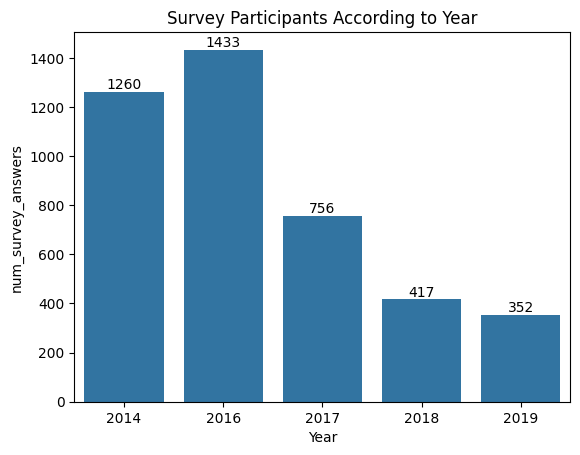

In [723]:
ax = sns.barplot(num_survey_year, x="Year", y="num_survey_answers")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Survey Participants According to Year")

The number of survey participants increases slightly between 2014-2016 and decreases after that. 

Age of survey participants: 

In [852]:
q = """ 
SELECT AnswerText Age, COUNT(AnswerText) Age_frequency
FROM Answer
WHERE QuestionID = 1
GROUP BY 1
ORDER BY 1
"""
age = pd.read_sql(q, connection)
age = age.astype({"Age": "int64"})
age.describe()


,Age,Age_frequency
count,65.000000,65.000000
mean,48.015385,64.892308
std,54.539977,79.612759
min,-29.000000,1.000000
25%,25.000000,3.000000
50%,41.000000,20.000000
75%,57.000000,122.000000
max,329.000000,250.000000


Some ages don't seem to make sense: 
- Accidental negative age
- Maximum of 329

Therefore, setting the age to be looked at as between 15 and 70 years old: 

In [853]:
age = age.drop(age[(age.Age < 15)].index)
age = age.drop(age[(age.Age > 70)].index)
age.describe()

,Age,Age_frequency
count,53.000000,53.000000
mean,42.018868,79.283019
std,15.543352,81.591944
min,15.000000,1.000000
25%,29.000000,9.000000
50%,42.000000,38.000000
75%,55.000000,147.000000
max,70.000000,250.000000


Half of survey participants who answered this question are aged between 25-57.

In a graph: 

[Text(0.5, 1.0, 'Age Frequency')]

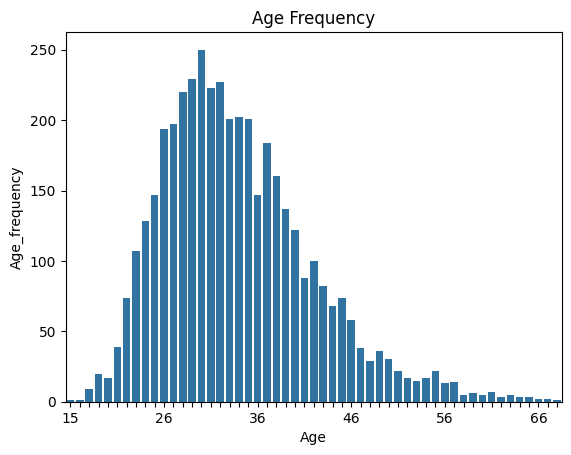

In [854]:
ax = sns.barplot(age, x="Age", y="Age_frequency")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set(title="Age Frequency")

This age frequency distribution is slightly skewed right.

Looking at gender: 

In [858]:
q = """ 
SELECT AnswerText Gender, COUNT(AnswerText) Gender_Frequency
FROM Answer
WHERE QuestionID = 2
GROUP BY AnswerText
ORDER BY AnswerText 
"""
gender = pd.read_sql(q, connection)
gender

,Gender,Gender_Frequency
0,-1,24
1,43,1
2,A little about you,1
3,AFAB,1
4,Agender,4
...,...,...
96,something kinda male?,1
97,sometimes,1
98,trans woman,1
99,transgender,1


This needs to be cleaned up a little bit: 

In [727]:
pd.reset_option("max_rows")
q = """ 
WITH t1 AS (
    SELECT AnswerText, 
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'
    WHEN AnswerText LIKE '%Fluid%' THEN 'Fluid'  
    WHEN AnswerText LIKE '%fluid%' THEN 'Fluid' 
    WHEN AnswerText LIKE '%Queer%' THEN 'Queer' 
    WHEN AnswerText LIKE '%queer%' THEN 'Queer' 
    WHEN AnswerText LIKE '%trans%' THEN 'Trans' 
    WHEN AnswerText LIKE '%Trans%' THEN 'Trans' 
    WHEN AnswerText LIKE '%Non binary%' THEN 'Non binary'
    WHEN AnswerText LIKE '%non-binary%' THEN 'Non binary'
    WHEN AnswerText LIKE '%nonbinary%' THEN 'Non binary' 
    WHEN AnswerText LIKE '%Agender%' THEN 'Agender' 
    WHEN AnswerText LIKE '%agender%' THEN 'Agender'   
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2)

SELECT gender Gender, COUNT(gender) Frequency, COUNT(gender) * 100.0 / (SELECT COUNT(gender) FROM t1) Percentage
FROM t1
GROUP BY gender
ORDER BY Frequency DESC
"""
gender = pd.read_sql(q, connection)
gender.head(10)

,Gender,Frequency,Percentage
0,Male,3048,72.261735
1,Female,1026,24.324324
2,Other,78,1.849218
3,Non binary,23,0.545282
4,Trans,14,0.331911
5,Queer,13,0.308203
6,Fluid,10,0.237079
7,Agender,6,0.142248


Over 95% of the participants are either female or male.

[Text(0.5, 1.0, 'Gender Frequency')]

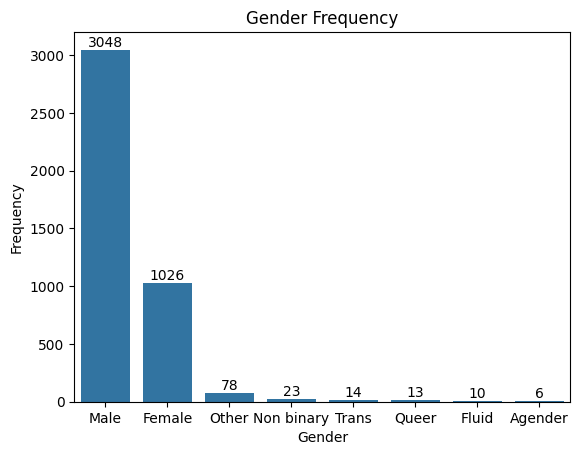

In [728]:
ax = sns.barplot(gender, x="Gender", y="Frequency")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Gender Frequency")

Mostly male or female participants.

Gender according to year: 

In [1046]:
pd.reset_option("max_rows")
q = """ 
SELECT SurveyID Year, COUNT(SurveyID) Frequency,
CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
WHEN AnswerText LIKE 'female' THEN 'Female' 
WHEN AnswerText LIKE 'MALE' THEN 'Male'
WHEN AnswerText LIKE '%Male%' THEN 'Male' 
WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
WHEN AnswerText LIKE 'male' THEN 'Male'
Else 'Other' END AS Gender
FROM Answer
WHERE QuestionID = 2
GROUP BY 1, 3
"""
gender = pd.read_sql(q, connection)
gender.head()

,Year,Frequency,Gender
0,2014,247,Female
1,2014,998,Male
2,2014,15,Other
3,2016,336,Female
4,2016,1064,Male


[Text(0.5, 1.0, 'Gender per Year')]

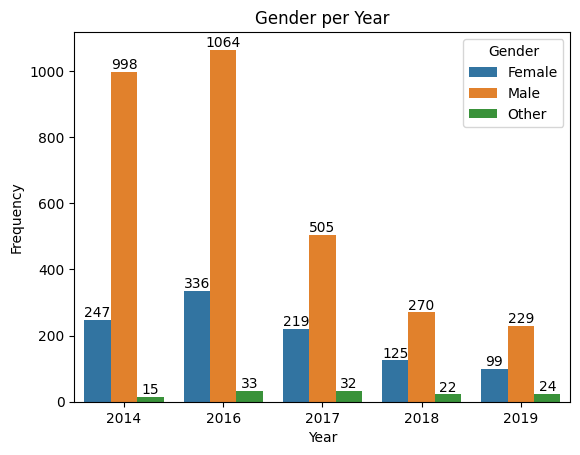

In [1058]:
ax = sns.barplot(gender, x="Year", y="Frequency", hue="Gender")
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set(title="Gender per Year")


The amount of 'other' genders is lowest in 2014. There are significantly more male than female participants, and all participant numbers decrease from 2016-2019 (especially male).

Now looking at country where participants live: 

In [877]:
q = """ 
WITH t1 AS (SELECT CASE WHEN AnswerText LIKE 'United States' THEN 'United States of America' 
WHEN AnswerText LIKE 'United States of America' THEN 'United States of America' 
WHEN AnswerText = -1 THEN 'Other'
ELSE AnswerText END AS home_country
FROM Answer
WHERE QuestionID = 3)

SELECT home_country, COUNT(home_country) home_country_frequency
FROM t1
GROUP BY 1
ORDER BY 2 DESC
"""
home_country = pd.read_sql(q, connection)
home_country


,home_country,home_country_frequency
0,United States of America,2604
1,United Kingdom,482
2,Canada,199
3,Germany,136
4,Netherlands,98
...,...,...
74,Ethiopia,1
75,Ecuador,1
76,Brunei,1
77,Belarus,1


Country where participants work: 

In [883]:
q = """ 
SELECT AnswerText work_country, COUNT(AnswerText) work_country_frequency
FROM Answer
WHERE QuestionID = 50
GROUP BY AnswerText
ORDER BY 2 DESC
LIMIT 10
"""
work_country = pd.read_sql(q, connection)
work_country

,work_country,work_country_frequency
0,United States of America,1872
1,United Kingdom,300
2,Canada,122
3,Germany,90
4,Netherlands,70
5,Australia,50
6,India,39
7,France,34
8,Brazil,30
9,Spain,24


Top 3 work countries: United States of America, United Kingdom, and Canada. 

Total number of participants for these three countries: 1872+300+122=2294

Looking at the frequency for home and work countries:

In [972]:
total_participants_USA_UK_Canada = 2294

In [881]:
q = """ 
WITH home AS (WITH t1 AS (SELECT CASE WHEN AnswerText LIKE 'United States' THEN 'United States of America' 
        WHEN AnswerText LIKE 'United States of America' THEN 'United States of America' 
        WHEN AnswerText = -1 THEN 'Other'
        ELSE AnswerText END AS home_country
        FROM Answer
        WHERE QuestionID = 3)

    SELECT home_country, COUNT(home_country) home_country_frequency
    FROM t1
    GROUP BY 1
    ORDER BY 2 DESC), 

work AS (SELECT AnswerText work_country, COUNT(AnswerText) work_country_frequency
    FROM Answer
    WHERE QuestionID = 50
    GROUP BY AnswerText
    ORDER BY 2 DESC)

SELECT home.home_country, work.work_country, home.home_country_frequency, work.work_country_frequency
FROM home
FULL JOIN work
ON home_country = work_country
LIMIT 10
"""
country = pd.read_sql(q, connection)
country

,home_country,work_country,home_country_frequency,work_country_frequency
0,United States of America,United States of America,2604,1872
1,United Kingdom,United Kingdom,482,300
2,Canada,Canada,199,122
3,Germany,Germany,136,90
4,Netherlands,Netherlands,98,70
5,Australia,Australia,73,50
6,Ireland,Ireland,51,23
7,France,France,51,34
8,India,India,50,39
9,Brazil,Brazil,37,30


In general for the top 10 countries, it seems that the home_country_frequency is higher than the work_country_frequency. For the rest of this analysis, the work_country_frequency will be used, as the topic involves the workplace.


[Text(0.5, 1.0, 'Work Country Frequency')]

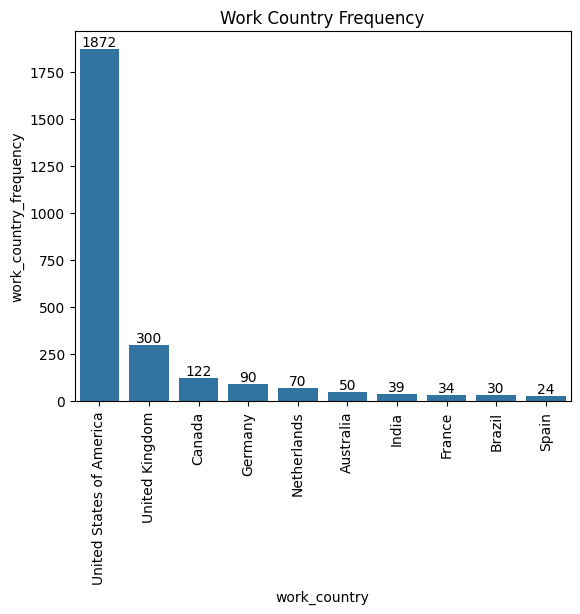

In [889]:
ax = sns.barplot(work_country, x="work_country", y="work_country_frequency")
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=90)
ax.set(title="Work Country Frequency")

Now, looking at race of participants (for the USA only): 

In [895]:
q = """ 
SELECT CASE WHEN AnswerText = -1 THEN 'N/A'
WHEN AnswerText LIKE 'I prefer not to answer' THEN 'N/A' 
ELSE AnswerText END AS race, COUNT(AnswerText) race_frequency
FROM Answer
WHERE QuestionID = 89
GROUP BY 1
ORDER BY 2 DESC
"""
race = pd.read_sql(q, connection)
race

,race,race_frequency
0,White,873
1,N/A,566
2,More than one of the above,35
3,Asian,31
4,Black or African American,15
5,White Hispanic,1
6,Hispanic,1
7,European American,1
8,Caucasian,1
9,American Indian or Alaska Native,1


Race in USA according to Survey Year: 

[Text(0.5, 1.0, 'Race frequency in the United States')]

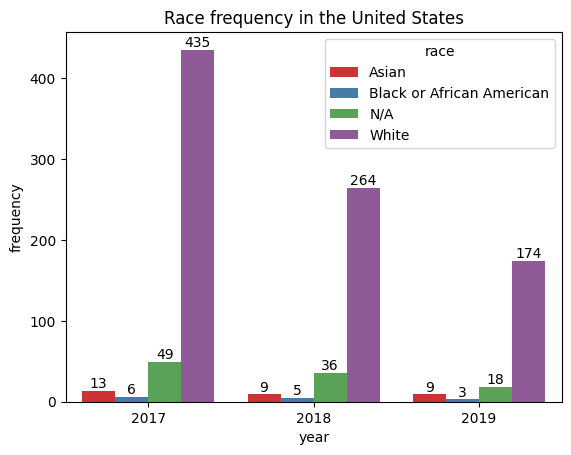

In [1059]:
q = """ 
WITH t1 AS (SELECT UserID, SurveyID, CASE WHEN AnswerText LIKE 'White' THEN 'White'
WHEN AnswerText LIKE 'Caucasian' THEN 'White' 
WHEN AnswerText LIKE 'Asian' THEN 'Asian' 
WHEN AnswerText LIKE 'Black or African American' THEN 'Black or African American'
Else 'N/A' END AS race
FROM Answer
WHERE QuestionID = 89), 

t2 AS (SELECT AnswerText work_country, UserID
FROM Answer
WHERE QuestionID = 50)

SELECT t1.SurveyID year, t1.race, COUNT(t1.race) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
WHERE t2.work_country LIKE 'United States of America'
GROUP BY 1, 2
"""
race = pd.read_sql(q, connection)
sns.color_palette('Set1')

ax = sns.barplot(race, x="year", y="frequency", hue="race", palette='Set1')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)
ax.set(title="Race frequency in the United States")

The total answers to this question: 

In [663]:
q = """ 
WITH t1 AS (SELECT UserID, SurveyID, CASE WHEN AnswerText LIKE 'White' THEN 'White'
WHEN AnswerText LIKE 'Caucasian' THEN 'White' 
WHEN AnswerText LIKE 'Asian' THEN 'Asian' 
WHEN AnswerText LIKE 'Black or African American' THEN 'Black or African American'
Else 'N/A' END AS race
FROM Answer
WHERE QuestionID = 89), 

t2 AS (SELECT AnswerText work_country, UserID
FROM Answer
WHERE QuestionID = 50)

SELECT COUNT(t1.race) total_responses
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
WHERE t2.work_country LIKE 'United States of America'
"""
race = pd.read_sql(q, connection)
race

,total_responses
0,1021


Race data only given for survey years 2017-2019 for the USA. Most people identify as being 'White', though about half of the people who work in the USA have answered this question. 

General population of survey takers: 
- From the USA
- Aged between 29 and 55 years old
- Either identify as a male or female

For the rest of the project, looking only at people from the USA, UK, or Canada. 

Sampling bias: 
- There could be a race, country, or age sampling bias in this survey, due to the fact that surveys are given in a workplace (mostly pertaining to the tech industry), which could bias the sampling probability. For example, the fact that the survey sample consists mostly of white males or females from the USA could indicate that most surveys were given in the USA and not other countries. 

Moving on to look at the work conditions for participants:

## Work conditions

Number of employees in participant's organization: 

[Text(0.5, 1.0, "Number of Employees in Particpant's Work Place")]

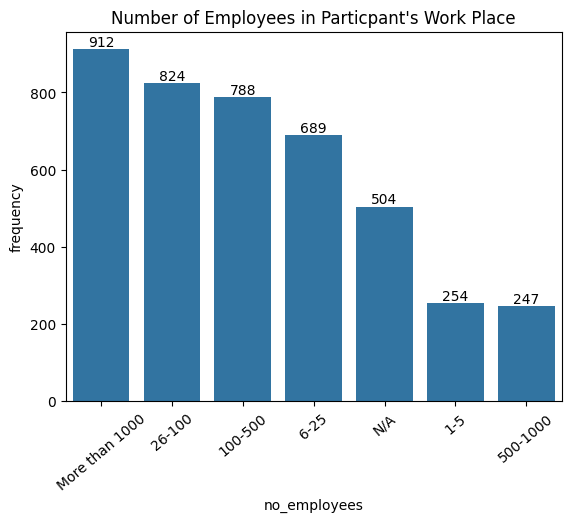

In [901]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText = -1 THEN 'N/A' 
ELSE AnswerText END AS no_employees
FROM Answer
WHERE QuestionID = 8
GROUP BY AnswerText
ORDER BY 1 DESC

"""
no_employees = pd.read_sql(q, connection)

ax = sns.barplot(no_employees, x="no_employees", y="frequency")
plt.xticks(rotation=40)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Number of Employees in Particpant's Work Place")

Survey participants work in companies with variable amounts of staff.

What kind of positions do survey participants? 

*Note: this question was only given in 2016.

In [666]:
q = """ 
SELECT AnswerText position, COUNT(AnswerText) frequency
FROM Answer
WHERE QuestionID = 117
GROUP BY AnswerText
ORDER BY 2 DESC
"""
position = pd.read_sql(q, connection)
position

,position,frequency
0,Back-end Developer,737
1,Front-end Developer,502
2,DevOps/SysAdmin,282
3,Supervisor/Team Lead,277
4,Other,187
5,Support,168
6,One-person shop,161
7,Designer,135
8,Executive Leadership,101
9,Dev Evangelist/Advocate,99


[Text(0.5, 1.0, 'Company Position in 2016 According to Gender')]

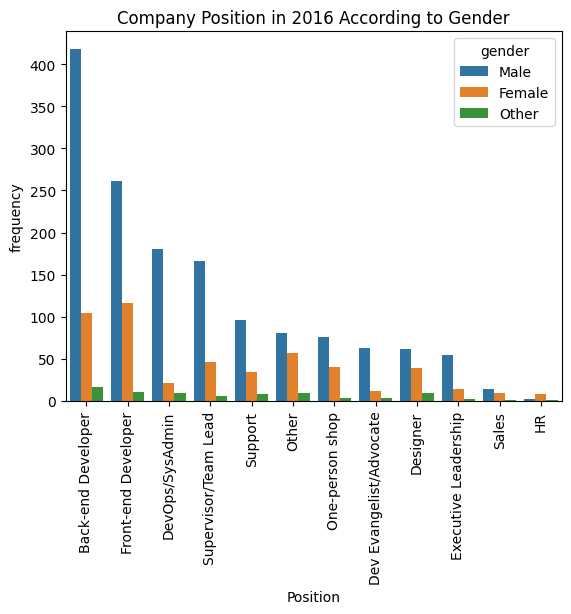

In [905]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText
    FROM Answer
    WHERE QuestionID = 117)

SELECT t1.gender, t3.AnswerText Position, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

ax = sns.barplot(c, x="Position", y="frequency", hue="gender")
plt.xticks(rotation=90)
ax.set(title="Company Position in 2016 According to Gender")

For the USA, the UK, and Canada, the most popular position is a developer. Women are more present than men only in the HR sector in 2016.

Do most survey participants have a tech role? 

In [909]:
q = """ 
SELECT COUNT(AnswerText) frequency,  CASE WHEN AnswerText = 1 THEN 'Yes' 
WHEN AnswerText = 0 THEN 'No' 
ELSE 'N/A' END AS tech_role
FROM Answer
WHERE QuestionID = 13
GROUP BY AnswerText
ORDER BY 2 DESC
"""
tech_role = pd.read_sql(q, connection)
tech_role = tech_role.assign(Percent = lambda x: x.frequency / total_participants * 100)
tech_role

,frequency,tech_role,Percent
0,1471,Yes,34.874348
1,100,No,2.370792
2,1387,N/A,32.882883


Note: the percent column is the percentage of total survey participants. An approximately equal amount of participants either have a tech role or did not answer the question.

Looking at this through survey years: 

[Text(0.5, 1.0, 'Tech role or not from 2016-2019')]

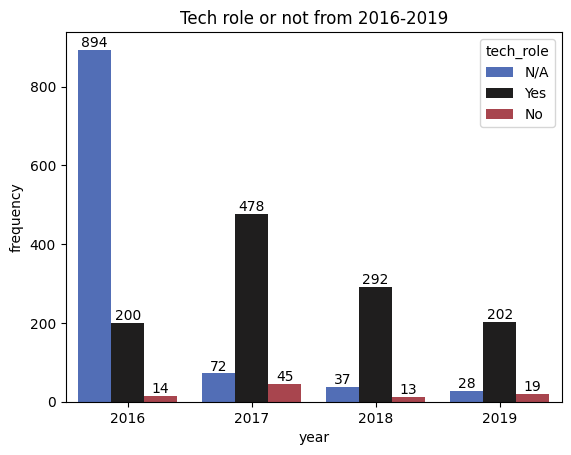

In [1086]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = 1 THEN 'Yes' 
    WHEN AnswerText = 0 THEN 'No' 
    Else 'N/A' END AS tech_role
    FROM Answer
    WHERE QuestionID = 13)

SELECT t1.SurveyID year, t3.tech_role, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)
c.head(15)

sns.color_palette('icefire')
ax = sns.barplot(c, x="year", y="frequency", hue="tech_role", palette='icefire')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Tech role or not from 2016-2019")

From 2017-2019, it is more likely for survey participants to have tech roles than not. Now looking at gender of participants:

[Text(0.5, 1.0, 'Tech role or not According to Gender')]

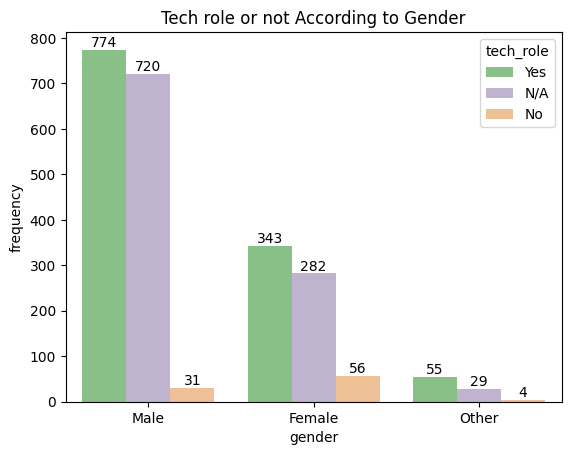

In [1075]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = 1 THEN 'Yes' 
    WHEN AnswerText = 0 THEN 'No' 
    Else 'N/A' END AS tech_role
    FROM Answer
    WHERE QuestionID = 13)

SELECT t1.gender, t3.tech_role, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)
sns.color_palette('Accent')

ax = sns.barplot(c, x="gender", y="frequency", hue="tech_role", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Tech role or not According to Gender")

When grouped by gender, survey participants' occupations are more related to tech than other things.

Next, looking at the question: 'Does your employer provide mental health benefits as part of healthcare coverage?': 

In [931]:
q = """ 
SELECT CASE WHEN AnswerText = -1 THEN 'N/A'
WHEN AnswerText LIKE 'Not eligible for coverage / NA' THEN 'N/A'
WHEN AnswerText LIKE '%know' THEN 'N/A' 
ELSE AnswerText END AS employer_mental_health_benefits, COUNT(AnswerText) frequency
FROM Answer
WHERE QuestionID = 10
GROUP BY 1
ORDER BY 2 DESC
"""
employer_insurance = pd.read_sql(q, connection)
employer_insurance = employer_insurance.assign(Percent = lambda x: x.frequency / total_participants * 100)

employer_insurance

,employer_mental_health_benefits,frequency,Percent
0,Yes,1744,41.346610
1,N/A,1718,40.730204
2,No,756,17.923186


Note: percentage here is a percentage of the total survey participants. 

Out of the total sample, most survey participants have mental health benefits as part of their insurance plan from work.

[Text(0.5, 1.0, 'Mental Health Benefits From Employer According to Gender')]

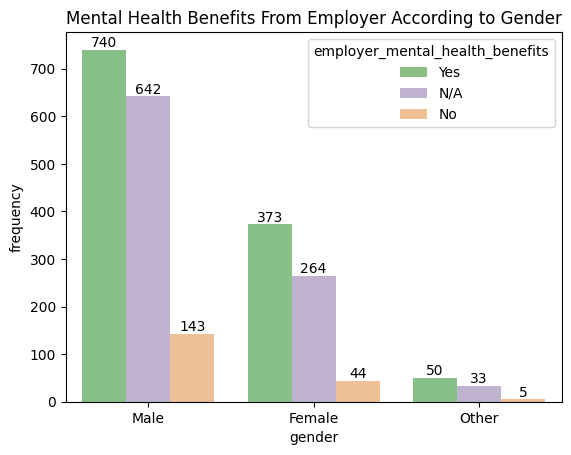

In [1074]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE '%know' THEN 'N/A'
    WHEN AnswerText LIKE 'Not eligible for coverage / NA' THEN 'N/A' 
    ELSE AnswerText END AS employer_mental_health_benefits
    FROM Answer
    WHERE QuestionID = 10)

SELECT t1.gender gender, t3.employer_mental_health_benefits, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="employer_mental_health_benefits", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Mental Health Benefits From Employer According to Gender")

Most survey participants have mental health benefits as part of their employment health insurance. Now, do most of these people know about the mental health benefits as part of their company insurance?

The exact question to look at here is: 'Do you know the options for mental health care available under your employer-provided health coverage?'

In [944]:
q = """ 
WITH t1 AS (SELECT CASE WHEN AnswerText = -1 THEN 'N/A'
WHEN AnswerText LIKE 'I am not sure' THEN 'N/A' 
ELSE AnswerText END AS insurance_options_mental_health
FROM Answer
WHERE QuestionID = 14)

SELECT insurance_options_mental_health, COUNT(insurance_options_mental_health) frequency
FROM t1
GROUP BY 1
ORDER BY 2 DESC
"""
options_care = pd.read_sql(q, connection)
options_care

,insurance_options_mental_health,frequency
0,N/A,1119
1,No,970
2,Yes,869


In total, more survey participants don't know about their insurance options for mental health care.

[Text(0.5, 1.0, 'Awareness About Mental Health Options for Current Insurance')]

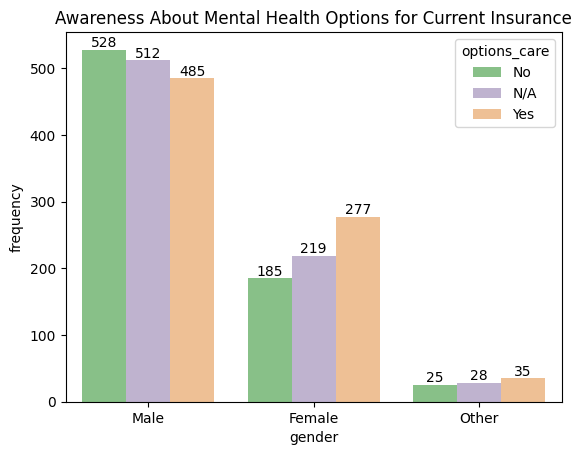

In [1087]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE 'I am not sure' THEN 'N/A'
    ELSE AnswerText END AS options_care
    FROM Answer
    WHERE QuestionID = 14)

SELECT t1.gender gender, t3.options_care, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="options_care", palette='Accent')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Awareness About Mental Health Options for Current Insurance")

Many survey particiapnts do not know about the mental health options for their current insurance. In general, female and other genders are more aware of the mental health options under their work insurance than males. 

From this, it is possible to note that most survey participants in the USA, UK, and Canada work in companies with variable sizes with roles mostly related to tech. Their companies generally provide some type of health insurance.

## Mental Health Variables

Do survey participants have a family history of mental health issues? 

In [946]:
q = """ 
SELECT AnswerText family_hist_mental_health, COUNT(AnswerText) frequency
FROM Answer
WHERE QuestionID = 6
GROUP BY AnswerText
ORDER BY 2 DESC
"""
fam_hist = pd.read_sql(q, connection)
fam_hist = fam_hist.assign(Percent = lambda x: x.frequency / total_participants * 100)

fam_hist

,family_hist_mental_health,frequency,Percent
0,Yes,1868,44.286392
1,No,1701,40.327169
2,I don't know,649,15.386439


[Text(0.5, 1.0, 'Mental Health Family History')]

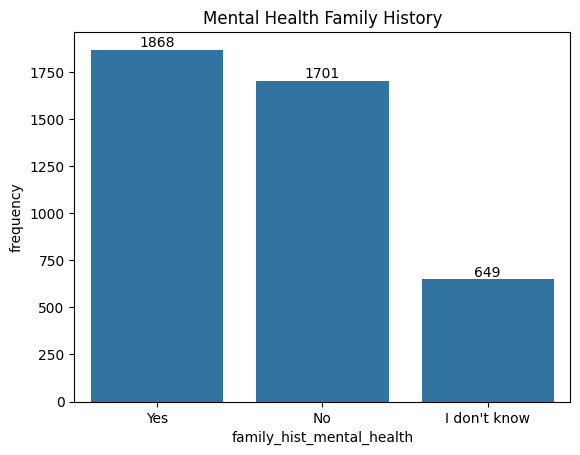

In [1088]:
ax = sns.barplot(fam_hist, x="family_hist_mental_health", y="frequency")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Mental Health Family History")

44% of all survey participants have a history of mental health issues. 

Now, looking at this grouped by work country:

[Text(0.5, 1.0, 'Work Country and Family History')]

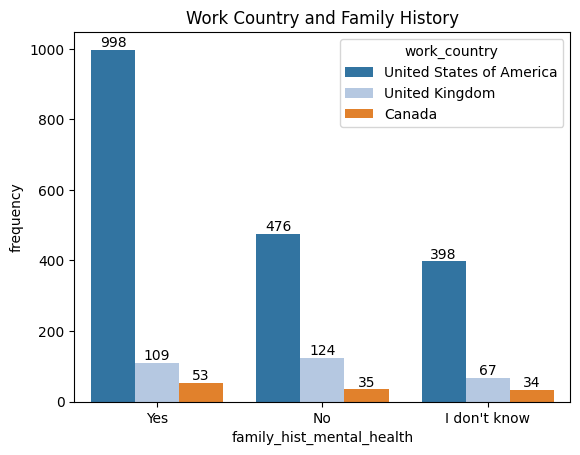

In [1090]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText
    FROM Answer
    WHERE QuestionID = 6)

SELECT t2.work_country, t3.AnswerText family_hist_mental_health, COUNT(t2.work_country) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('tab20')
ax = sns.barplot(c, x="family_hist_mental_health", y="frequency", hue="work_country", palette='tab20')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.set(title="Work Country and Family History")

In the USA, more people have a family history of mental health than not, while most people who answered this question in the UK do not. 

Now, looking at the question 'Have you ever sought treatment for a mental health disorder from a mental health professional?':

In [948]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText = 1 THEN 'Yes' 
ELSE 'No' END AS sought_treatment
FROM Answer
WHERE QuestionID = 7
GROUP BY AnswerText
ORDER BY 2 DESC
"""
sought_treatment = pd.read_sql(q, connection)
sought_treatment = sought_treatment.assign(Percent = lambda x: x.frequency / total_participants * 100)

sought_treatment

,frequency,sought_treatment,Percent
0,2412,Yes,57.183499
1,1806,No,42.816501


57% of the sample have sought professional treatment for mental health issues in the past. 

Looking at this grouped by work country gives:

[Text(0.5, 1.0, 'Mental Health Treatment Sought')]

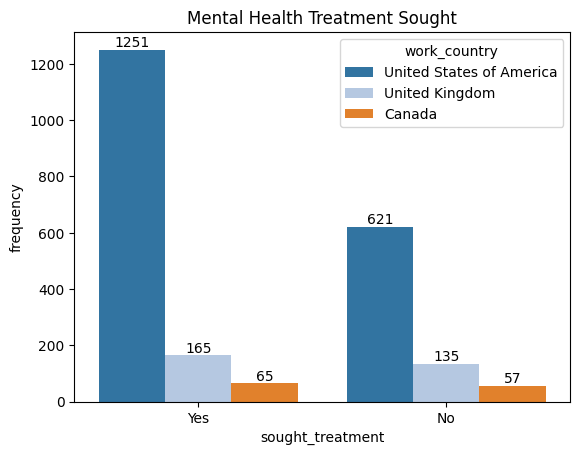

In [1091]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = 1 THEN 'Yes' ELSE 'No' END AS sought_treatment
    FROM Answer
    WHERE QuestionID = 7)

SELECT t2.work_country, t3.sought_treatment, COUNT(t2.work_country) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('tab20')
ax = sns.barplot(c, x="sought_treatment", y="frequency", hue="work_country", palette='tab20')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.set(title="Mental Health Treatment Sought")

Many more people in the USA have sought treatment for mental health issues than not. This difference is much smaller in the UK and Canada, though the trend is still present.

Now, looking at participants with past mental health disorders: 


(Note: the exact question is: 'Have you had a mental health disorder in the past?')

[Text(0.5, 1.0, 'Past Mental Health Disorder')]

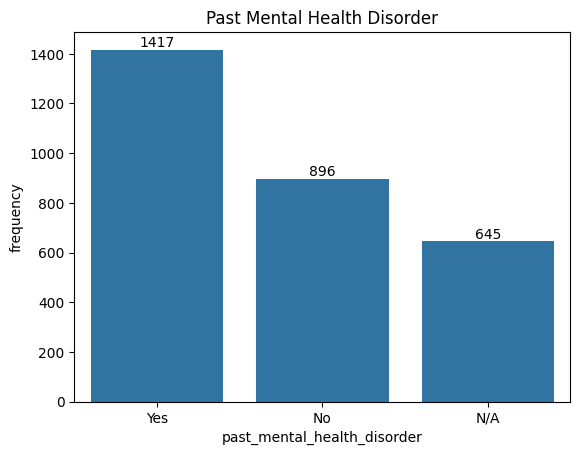

In [961]:
q = """ 
WITH t1 AS (SELECT CASE WHEN AnswerText LIKE 'Possibly' THEN 'N/A'
WHEN AnswerText = -1 THEN 'N/A' 
WHEN AnswerText LIKE '%know' THEN 'N/A'
WHEN AnswerText LIKE 'Maybe' THEN 'N/A'
ELSE AnswerText END AS past_mental_health_disorder
FROM Answer
WHERE QuestionID = 32)

SELECT past_mental_health_disorder, COUNT(past_mental_health_disorder) frequency
FROM t1
GROUP BY 1
ORDER BY frequency DESC
"""
past_mental_health_disorder = pd.read_sql(q, connection)
ax = sns.barplot(
    past_mental_health_disorder, x="past_mental_health_disorder", y="frequency"
)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Past Mental Health Disorder")


Most survey participants have had a past mental health disorder. Looking at this in the USA, UK, and Canada grouped by gender: 

[Text(0.5, 1.0, 'Past Mental Health Disorder')]

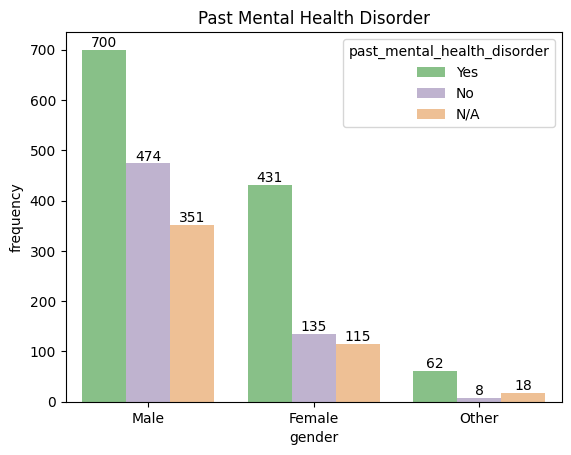

In [1092]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'N/A'
    WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE '%know' THEN 'N/A'
    WHEN AnswerText LIKE 'Maybe' THEN 'N/A'
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32)

SELECT t1.gender gender, t3.past_mental_health_disorder, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="past_mental_health_disorder", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.set(title="Past Mental Health Disorder")

Compared to males, females and other genders have higher proportions of past mental health disorders.

Looking at current mental health disorders:

[Text(0.5, 1.0, 'Current Mental Health Disorder')]

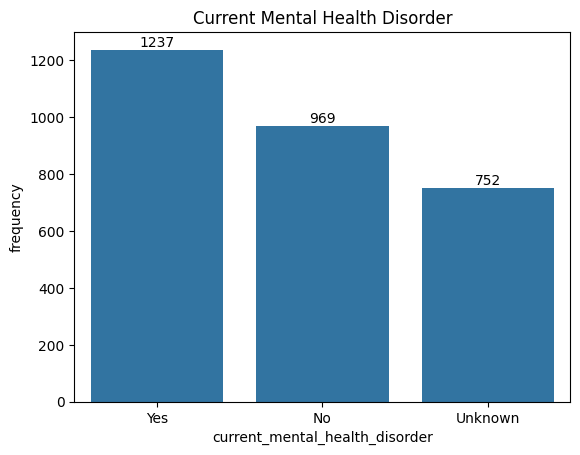

In [965]:
q = """ 
WITH t1 AS (SELECT CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
WHEN AnswerText LIKE 'No' THEN 'No' 
ELSE 'Unknown' END AS current_mental_health_disorder
FROM Answer
WHERE QuestionID = 33)

SELECT current_mental_health_disorder, COUNT(*) frequency
FROM t1
GROUP BY 1
ORDER BY 2 DESC

"""
current_mental_health_disorder = pd.read_sql(q, connection)
ax = sns.barplot(
    current_mental_health_disorder, x="current_mental_health_disorder", y="frequency"
)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Current Mental Health Disorder")

More often than not, survey respondants have current mental health disorders. For the top three countries represented in the survey: 

[Text(0.5, 1.0, 'Current Mental Health Disorder')]

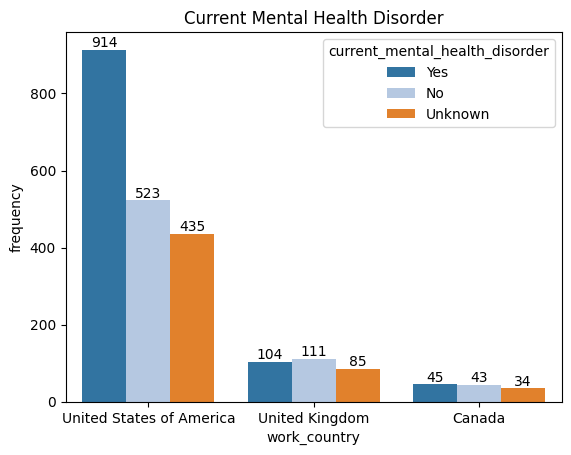

In [1093]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33)

SELECT t2.work_country, t3.current_mental_health_disorder, COUNT(t2.work_country) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('tab20')

ax = sns.barplot(c, x="work_country", y="frequency", hue="current_mental_health_disorder", palette='tab20')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Current Mental Health Disorder")

There is a higher proportion of mental health disorders in the USA than in the UK or in Canada. It is important to note that most survey participants are from the USA. 

Now, looking at current mental health disorders in the USA, UK, and Canada grouped by gender:

[Text(0.5, 1.0, 'Current Mental Health Disorder - Gender')]

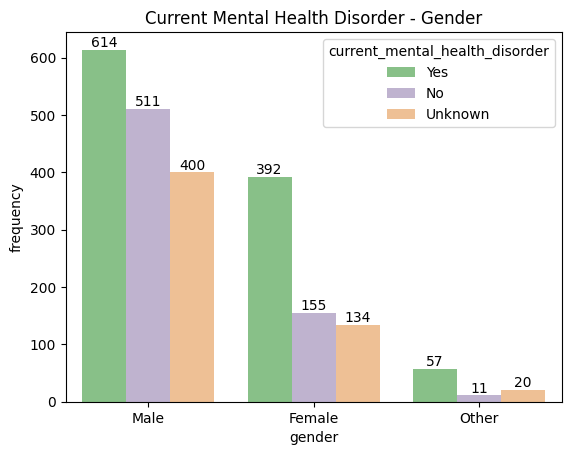

In [1094]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33)

SELECT t1.gender gender, t3.current_mental_health_disorder, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')

ax = sns.barplot(c, x="gender", y="frequency", hue="current_mental_health_disorder", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Current Mental Health Disorder - Gender")

It seems there is a higher proportion of females and other genders that have current mental health disorders as compared to males in the USA, UK, and Canada. 

Now, looking at survey participants who have been diagnosed with mental illnesses (exact question: 'Have you ever been diagnosed with a mental health disorder?'):

In [968]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText = -1 THEN 'N/A' 
ELSE AnswerText END AS diagnosis
FROM Answer
WHERE QuestionID = 34
GROUP BY 2
ORDER BY 2 DESC
"""
diagnosis = pd.read_sql(q, connection)
diagnosis = diagnosis.assign(Percent_total_participants = lambda x: x.frequency / total_participants * 100)

diagnosis

,frequency,diagnosis,Percent_total_participants
0,1363,Yes,32.313893
1,732,No,17.354196
2,863,N/A,20.459934


Most survey partipants have been diagnosed with a mental health condition at some point. Looking at this according to year in the USA, UK, and Canada:

[Text(0.5, 1.0, 'Diagnosed with Mental Health Disorder')]

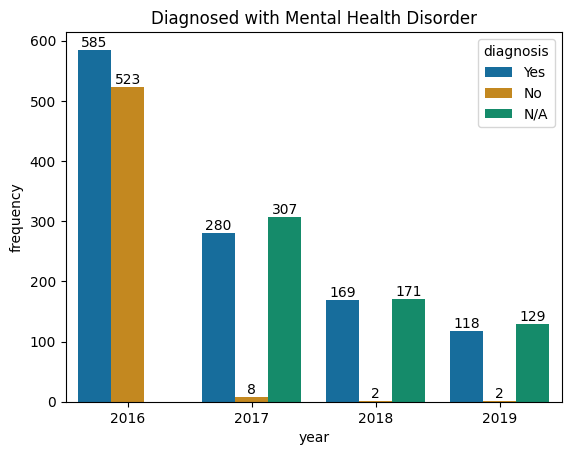

In [1098]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34)

SELECT t1.SurveyID year, t3.diagnosis, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')
ax = sns.barplot(c, x="year", y="frequency", hue="diagnosis", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Diagnosed with Mental Health Disorder")

In each year in the USA, UK, and Canada, similar amounts of survey respondants have been diagnosed with a mental health disorder, of this question is not applicable. 

## Diagnosed Condition Prevalence Rates

Top five diagnosed conditions for all survey participants:

In [976]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText = -1 THEN 'N/A' ELSE AnswerText END AS diagnosed_condition
FROM Answer
WHERE QuestionID = 115
GROUP BY AnswerText
ORDER BY 1 DESC
LIMIT 6
"""
diagnosed_condition = pd.read_sql(q, connection)
diagnosed_condition = diagnosed_condition.drop(diagnosed_condition[(diagnosed_condition.diagnosed_condition == 'N/A')].index)
diagnosed_condition = diagnosed_condition.assign(Percent_total_participants = lambda x: x.frequency / total_participants * 100)

diagnosed_condition

,frequency,diagnosed_condition,Percent_total_participants
1,412,"Mood Disorder (Depression, Bipolar Disorder, etc)",9.767662
2,345,"Anxiety Disorder (Generalized, Social, Phobia, etc)",8.179232
3,121,Attention Deficit Hyperactivity Disorder,2.868658
4,69,Post-traumatic Stress Disorder,1.635846
5,45,Obsessive-Compulsive Disorder,1.066856


Defining a function to create the ratio for the diagnosed condition compared to the sample size: 

Here, p_hat is the ratio of the diagnosed_condition compared to the total survey sample of 4218.

In [980]:
diagnosed_condition = diagnosed_condition.assign(
    p_hat=lambda x: (1.0 * x.frequency) / (1.0 * total_participants)
)
diagnosed_condition

,frequency,diagnosed_condition,Percent_total_participants,p_hat
1,412,"Mood Disorder (Depression, Bipolar Disorder, etc)",9.767662,0.097677
2,345,"Anxiety Disorder (Generalized, Social, Phobia, etc)",8.179232,0.081792
3,121,Attention Deficit Hyperactivity Disorder,2.868658,0.028687
4,69,Post-traumatic Stress Disorder,1.635846,0.016358
5,45,Obsessive-Compulsive Disorder,1.066856,0.010669


Now, including the margin of error (ME):

The function 'ME' returns the margin of error for a given variable in the total population using a 95% confidence level.

In [981]:
def ME(x):
    n = total_participants
    z = 1.96
    phat = (x * 1.0) / (n * 1.0)
    if (n * phat) > 5 and (n * (1 - phat)) > 5:
        SE = m.sqrt((phat * (1 - phat)) / n)
        margin_error = z * SE
        return margin_error
    else:
        return "Not large enough sample size"

In [982]:
diagnosed_condition["ME"] = diagnosed_condition["frequency"].apply(ME)
diagnosed_condition

,frequency,diagnosed_condition,Percent_total_participants,p_hat,ME
1,412,"Mood Disorder (Depression, Bipolar Disorder, etc)",9.767662,0.097677,0.008959
2,345,"Anxiety Disorder (Generalized, Social, Phobia, etc)",8.179232,0.081792,0.008270
3,121,Attention Deficit Hyperactivity Disorder,2.868658,0.028687,0.005038
4,69,Post-traumatic Stress Disorder,1.635846,0.016358,0.003828
5,45,Obsessive-Compulsive Disorder,1.066856,0.010669,0.003100


Defining a function to properly wrap x labels: 

In [1136]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(labels, rotation=0)

Note: code for this function is from https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce.


Putting this into a plot: 

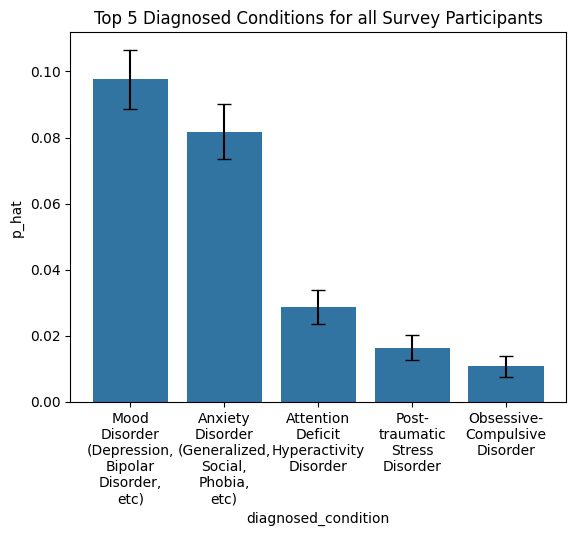

In [1137]:
ax = sns.barplot(x="diagnosed_condition", y="p_hat", data=diagnosed_condition)
wrap_labels(ax, 10)
plt.errorbar(
    diagnosed_condition.diagnosed_condition, diagnosed_condition.p_hat, yerr=diagnosed_condition.ME, fmt="none", c="black", capsize=5
)
plt.title("Top 5 Diagnosed Conditions for all Survey Participants")
plt.show()

Looking at diagnosed conditions for workers in the USA, UK, or Canada: 

In [999]:
q = """ 
WITH t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosed_condition
    FROM Answer
    WHERE QuestionID = 115)

SELECT t3.diagnosed_condition, COUNT(t3.diagnosed_condition) frequency
FROM t2
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1
ORDER BY frequency DESC
LIMIT 6
"""

diagnosed_condition_top3_countries = pd.read_sql(q, connection)
diagnosed_condition_top3_countries = diagnosed_condition_top3_countries.drop(diagnosed_condition_top3_countries[(diagnosed_condition_top3_countries.diagnosed_condition == 'N/A')].index)
diagnosed_condition_top3_countries = diagnosed_condition_top3_countries.assign(Percent_participants_top3_countries = lambda x: x.frequency / total_participants_USA_UK_Canada * 100)
diagnosed_condition_top3_countries

,diagnosed_condition,frequency,Percent_participants_top3_countries
1,"Mood Disorder (Depression, Bipolar Disorder, etc)",351,15.300785
2,"Anxiety Disorder (Generalized, Social, Phobia, etc)",296,12.903226
3,Attention Deficit Hyperactivity Disorder,111,4.838710
4,Post-traumatic Stress Disorder,62,2.702703
5,Obsessive-Compulsive Disorder,38,1.656495


In [1000]:
diagnosed_condition_top3_countries = diagnosed_condition_top3_countries.assign(
    p_hat=lambda x: (1.0 * x.frequency) / (1.0 * total_participants_USA_UK_Canada)
)
diagnosed_condition_top3_countries

,diagnosed_condition,frequency,Percent_participants_top3_countries,p_hat
1,"Mood Disorder (Depression, Bipolar Disorder, etc)",351,15.300785,0.153008
2,"Anxiety Disorder (Generalized, Social, Phobia, etc)",296,12.903226,0.129032
3,Attention Deficit Hyperactivity Disorder,111,4.838710,0.048387
4,Post-traumatic Stress Disorder,62,2.702703,0.027027
5,Obsessive-Compulsive Disorder,38,1.656495,0.016565


Note: Including the ratio of the number of diagnosed individuals who work in the USA, UK, or Canada as p_hat.

Now, including the margin of error (ME) for participants in the top 3 countries: 

In [1001]:
def ME(x):
    n = total_participants_USA_UK_Canada
    z = 1.96
    phat = (x * 1.0) / (n * 1.0)
    if (n * phat) > 5 and (n * (1 - phat)) > 5:
        SE = m.sqrt((phat * (1 - phat)) / n)
        margin_error = z * SE
        return margin_error
    else:
        return "Not large enough sample size"

In [1002]:
diagnosed_condition_top3_countries["ME"] = diagnosed_condition_top3_countries["frequency"].apply(ME)
diagnosed_condition_top3_countries

,diagnosed_condition,frequency,Percent_participants_top3_countries,p_hat,ME
1,"Mood Disorder (Depression, Bipolar Disorder, etc)",351,15.300785,0.153008,0.014732
2,"Anxiety Disorder (Generalized, Social, Phobia, etc)",296,12.903226,0.129032,0.013719
3,Attention Deficit Hyperactivity Disorder,111,4.838710,0.048387,0.008781
4,Post-traumatic Stress Disorder,62,2.702703,0.027027,0.006636
5,Obsessive-Compulsive Disorder,38,1.656495,0.016565,0.005223


Now plotting the top 5 diagnosed disorders in the top 3 countries:

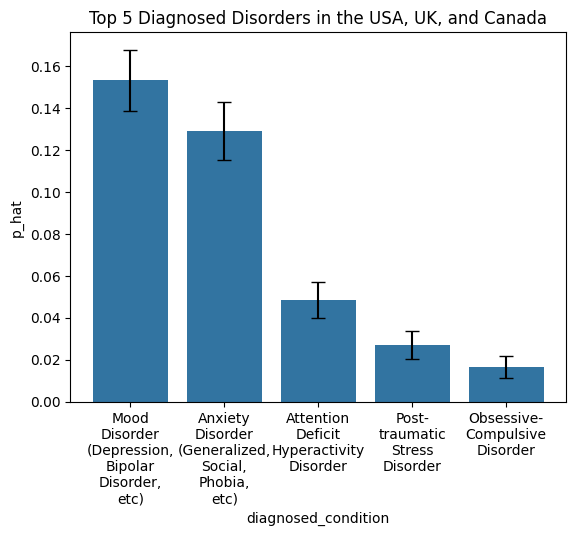

In [1135]:
ax = sns.barplot(x="diagnosed_condition", y="p_hat", data=diagnosed_condition_top3_countries)
plt.errorbar(
    diagnosed_condition_top3_countries.diagnosed_condition, diagnosed_condition_top3_countries.p_hat, yerr=diagnosed_condition_top3_countries.ME, fmt="none", c="black", capsize=5
)
plt.title("Top 5 Diagnosed Disorders in the USA, UK, and Canada")
wrap_labels(ax, 10)
plt.show()

These error bars show the margin of error with a 95% confidence level, which meants that the true proportion of people with mental health disorders for this sample lies in between this interval. 

From these two graphs, it is possible to see that in general, there is a higher sample of participants with these top 5 disorders in the USA, UK, and Canada than when looking at all countries together.

However, there are some key assumptions missing: 
- Not necessarily a random sample
- The entries are not necessarily independent from each other

## Mental Health Involvement with Work Output

Looking at people who identify as having a mental health disorder and the effect on their work. The exact question is : 

'If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?'

[Text(0.5, 1.0, 'Effective Treatment Work Interference')]

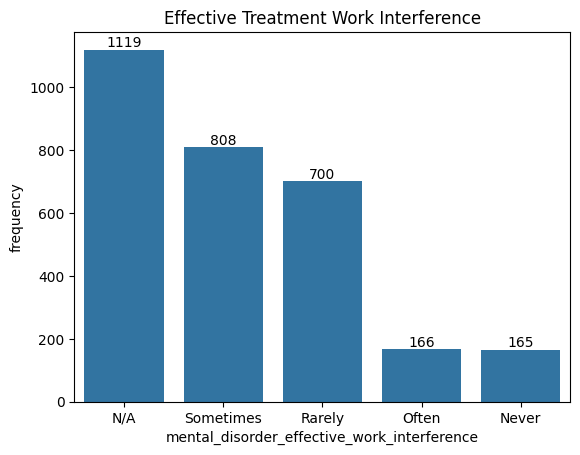

In [1004]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' ELSE AnswerText END AS mental_disorder_effective_work_interference
FROM Answer
WHERE QuestionID = 48
GROUP BY AnswerText
ORDER BY 1 DESC
"""
condition_interfere_work_treatment_effective = pd.read_sql(q, connection)
ax = sns.barplot(
    condition_interfere_work_treatment_effective,
    x="mental_disorder_effective_work_interference",
    y="frequency",
)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Effective Treatment Work Interference")

With an effective treatment, existing mental health conditions generally interfere with work rarely or sometimes.

Grouped by gender in the USA, UK, and Canada: 

[Text(0.5, 1.0, 'Effective Treatment Work Interference with Gender')]

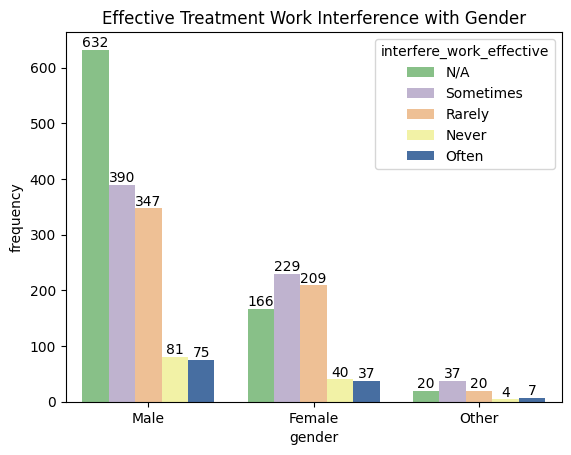

In [1099]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' ELSE AnswerText END AS interfere_work_effective
    FROM Answer
    WHERE QuestionID = 48)

SELECT t1.gender, t3.interfere_work_effective, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="interfere_work_effective", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)
ax.bar_label(ax.containers[4], fontsize=10)


ax.set(title="Effective Treatment Work Interference with Gender")

In the USA, UK, and Canada, people with mental health conditions and effective treatment do not find their work frequently affected by this. 

Now, looking at the opposite question: 'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?'

[Text(0.5, 1.0, 'Ineffective Treatment Work Interference')]

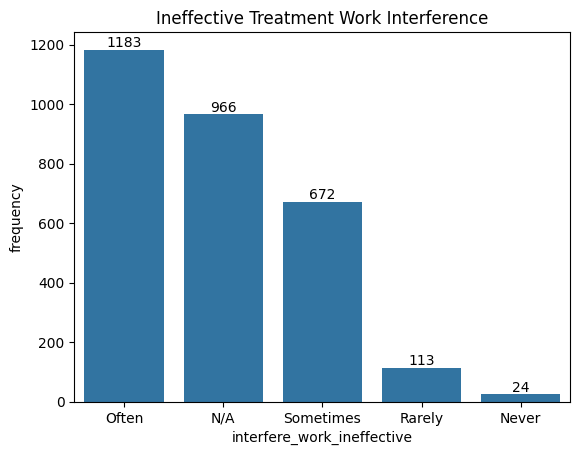

In [759]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' ELSE AnswerText END AS interfere_work_ineffective
FROM Answer
WHERE QuestionID = 49
GROUP BY AnswerText
ORDER BY 1 DESC
"""
condition_interfere_work_treatment_ineffective = pd.read_sql(q, connection)
ax = sns.barplot(
    condition_interfere_work_treatment_ineffective,
    x="interfere_work_ineffective",
    y="frequency",
)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title="Ineffective Treatment Work Interference")

Survey respondants with mental health conditions often find their work affected when their condition does not have an effective treatment.

Again, grouping this by gender for participants in the USA, UK and Canada:

[Text(0.5, 1.0, 'Ineffective Treatment Work Interference with Gender')]

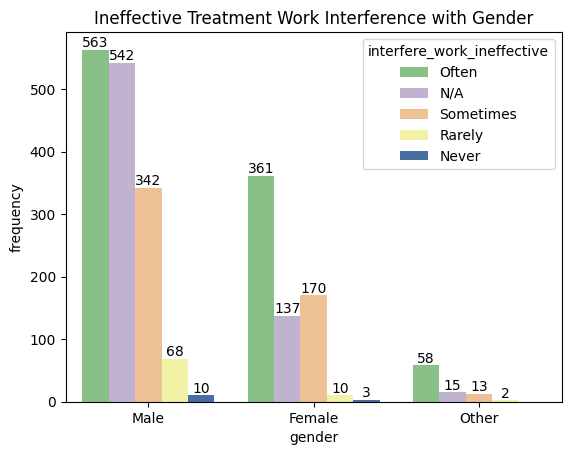

In [1100]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' ELSE AnswerText END AS interfere_work_ineffective
    FROM Answer
    WHERE QuestionID = 49)

SELECT t1.gender, t3.interfere_work_ineffective, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="interfere_work_ineffective", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)
ax.bar_label(ax.containers[4], fontsize=10)

ax.set(title="Ineffective Treatment Work Interference with Gender")

A similar trend is noticed here with gender divisions in the USA, UK, and Canada: with ineffective treatment, participants find that their work is affected by their mental health condition.

Now, looking at if survey participants feel that their work productivity suffers due to a mental health condition (exact question: 'Do you believe your productivity is ever affected by a mental health issue?'): 

In [1008]:
q = """ 
WITH t1 AS (SELECT CASE WHEN AnswerText = -1 THEN 'N/A' 
WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' 
ELSE AnswerText END AS condition_productivity_suffers
FROM Answer
WHERE QuestionID = 54) 
SELECT condition_productivity_suffers, COUNT(condition_productivity_suffers) frequency
FROM t1
GROUP BY 1
ORDER BY 2
"""
condition_productivity_suffers = pd.read_sql(q, connection)
condition_productivity_suffers = condition_productivity_suffers.assign(Percent_total_participants = lambda x: x.frequency / total_participants * 100)

condition_productivity_suffers

,condition_productivity_suffers,frequency,Percent_total_participants
0,No,26,0.616406
1,Unsure,60,1.422475
2,Yes,367,8.700806
3,N/A,2505,59.388336


Quite a few people did not answer this question or found it not applicable to them, as the percentages here do not add up to 100. The only interesting thing to note here is that almost 9% of participants say that their productivity is affected by a mental health condition.

Grouped by gender for participants in the USA, UK, and Canada:

[Text(0.5, 1.0, 'Productivity Affected with Gender')]

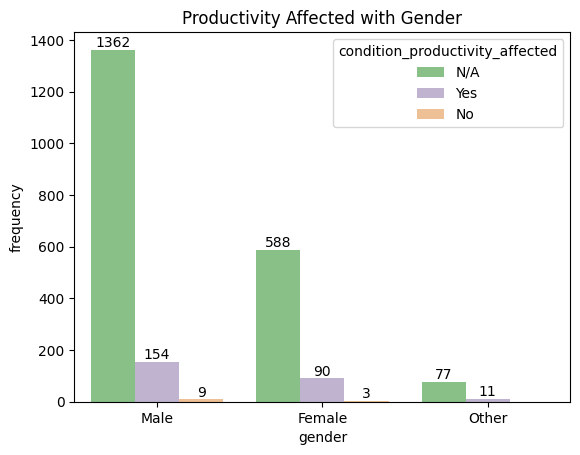

In [1101]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' 
    WHEN AnswerText LIKE 'Unsure' THEN 'N/A'
    ELSE AnswerText END AS condition_productivity_affected
    FROM Answer
    WHERE QuestionID = 54)

SELECT t1.gender, t3.condition_productivity_affected, COUNT(t1.gender) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('Accent')
ax = sns.barplot(c, x="gender", y="frequency", hue="condition_productivity_affected", palette='Accent')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)


ax.set(title="Productivity Affected with Gender")

This graph shows that a small amount of survey respondants in the USA, UK, and Canada with mental health problems believe that this impacts their work productivity. This trend is seen with all genders; however, most participants found that this question was not applicable to them.

Now, out of the almost 9% of survey respondants that answered the previous question with 'yes', the next question looks at the percentage of work that is affected by mental health disturbances. The exact question is: 'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?'

In [1016]:
q = """ 
SELECT COUNT(AnswerText) frequency, CASE WHEN AnswerText = -1 THEN 'N/A' ELSE AnswerText END AS percent_work_affected
FROM Answer
WHERE QuestionID = 55
GROUP BY AnswerText
ORDER BY 2 DESC
"""
percent_work_affected = pd.read_sql(q, connection)
percent_work_affected = percent_work_affected.assign(Percent_total_participants = lambda x: x.frequency / total_participants * 100)

percent_work_affected

,frequency,percent_work_affected,Percent_total_participants
0,2591,N/A,61.427217
1,25,76-100%,0.592698
2,53,51-75%,1.256520
3,125,26-50%,2.963490
4,164,1-25%,3.888099


Again, this question is not relevant to most survey participants. 

Now, dropping non applicable answers and looking only at participants in the top 3 countries gives: 

[Text(0.5, 1.0, 'Percent Work Time Affected Given Mental Health Condition')]

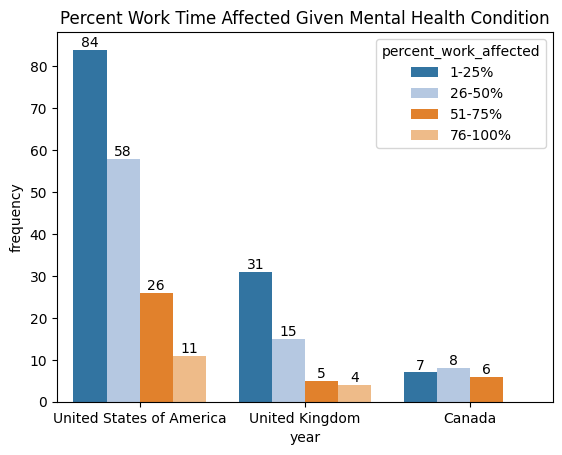

In [1102]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' ELSE AnswerText END AS percent_work_affected
    FROM Answer
    WHERE QuestionID = 55)

SELECT t2.work_country year, t3.percent_work_affected, COUNT(t2.work_country) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
WHERE (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)
c = c.drop(c[(c.percent_work_affected == 'N/A')].index)

sns.color_palette('tab20')
ax = sns.barplot(c, x="year", y="frequency", hue="percent_work_affected", palette='tab20')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)


ax.set(title="Percent Work Time Affected Given Mental Health Condition")



Out of the few participants with mental health conditions that affect work output, mostly up to a quarter of participant's work time is affected by their mental health disease. This trend is seen in the UK but not in Canada.

## Grouping Variables and Conclusions:

Looking at participant's answer to having a current mental health disorder who answered 'yes' to having a past mental health disorder as well as 'yes' to having a family history of mental health disorders, in the USA, UK, or Canada: 

Note: grouped by year

[Text(0.5, 1.0, 'Current Disorder with Family History and Past Disorder')]

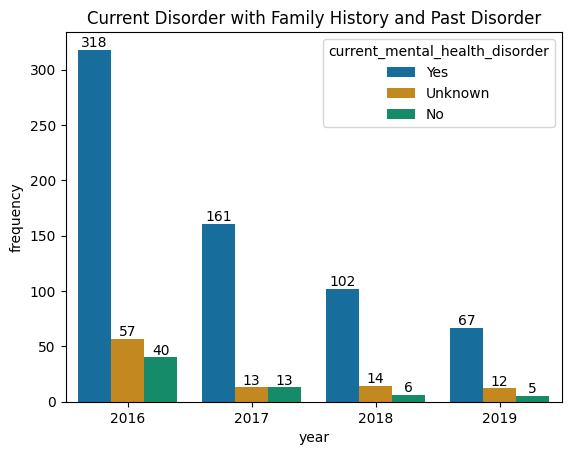

In [1139]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText family_hist
    FROM Answer
    WHERE QuestionID = 6), 

t4 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'Maybe'
    WHEN AnswerText = -1 THEN 'NA' 
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32), 

t5 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34),

t6 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33)


SELECT t1.SurveyID year, t6.current_mental_health_disorder, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
JOIN t4
ON t3.UserID = t4.UserID
JOIN t5 
ON t4.UserID = t5.UserID
JOIN t6
ON t5.UserID = t6.UserID
WHERE t4.past_mental_health_disorder LIKE 'yes' AND t3.family_hist LIKE 'yes' AND (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')
ax = sns.barplot(c, x="year", y="frequency", hue="current_mental_health_disorder", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Current Disorder with Family History and Past Disorder")

After answering 'yes' to a family history of mental health issues and 'yes' to having a past mental health disorder, participants in the USA, UK, and Canada also answer mostly 'yes' to having a current mental health disorder. 

Now, looking at the opposite effect: 
Looking at participant's answers to having a current mental health disorder who answered 'no' to having a past mental health disorder as well as 'no' to having a family history of mental health disorders, in the USA, UK, or Canada: 

Note: also grouped by year

[Text(0.5, 1.0, 'Current Disorder with No Family History and No Past Disorder')]

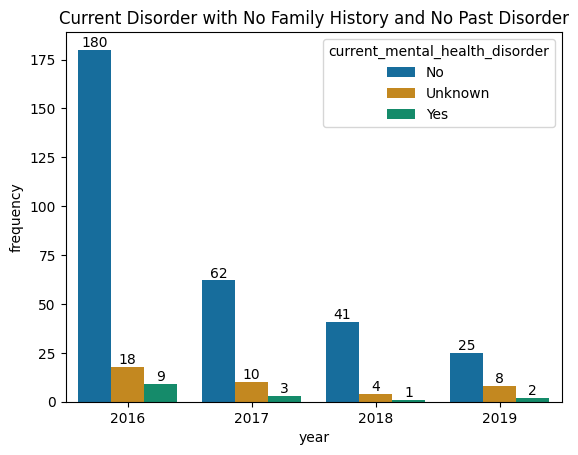

In [1104]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText family_hist
    FROM Answer
    WHERE QuestionID = 6), 

t4 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'Maybe'
    WHEN AnswerText = -1 THEN 'NA' 
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32), 

t5 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34),

t6 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33)


SELECT t1.SurveyID year, t6.current_mental_health_disorder, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
JOIN t4
ON t3.UserID = t4.UserID
JOIN t5 
ON t4.UserID = t5.UserID
JOIN t6
ON t5.UserID = t6.UserID
WHERE t4.past_mental_health_disorder LIKE 'No' AND t3.family_hist LIKE 'No' AND (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')
ax = sns.barplot(c, x="year", y="frequency", hue="current_mental_health_disorder", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)

ax.set(title="Current Disorder with No Family History and No Past Disorder")

On the contrary, when survey respondants answer 'no' to having a family history of mental health issues and 'no' to previous mental health issues, they most frequently do not seem to have a current mental health disorder.

Next, given a negative response to the previous questions: 
- 'No' to current mental health disorder, 
- 'No' to past mental health disorder
- 'No' to having a family history of mental health disorders, 

do participants working in the USA, UK, or Canada find their work productivity affected through 2016-2019? 

[Text(0.5, 1.0, 'Productivity affected After Negative Response to Previous Questions')]

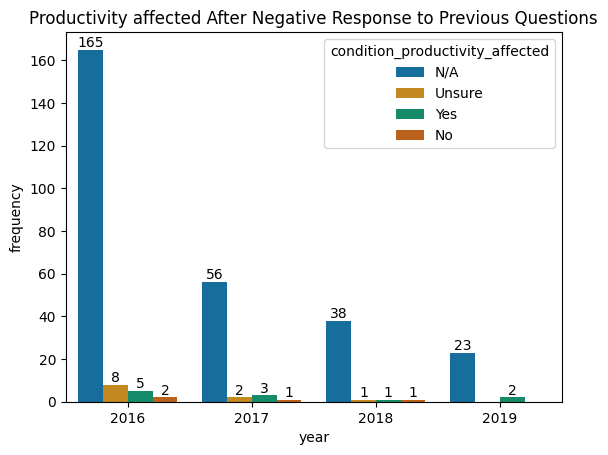

In [1105]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText family_hist
    FROM Answer
    WHERE QuestionID = 6), 

t4 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'Maybe'
    WHEN AnswerText = -1 THEN 'NA' 
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32), 

t5 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34),

t6 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33), 

t7 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' 
    ELSE AnswerText END AS condition_productivity_affected
    FROM Answer
    WHERE QuestionID = 54)


SELECT t1.SurveyID year, t7.condition_productivity_affected, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
JOIN t4
ON t3.UserID = t4.UserID
JOIN t5 
ON t4.UserID = t5.UserID
JOIN t6
ON t5.UserID = t6.UserID
JOIN t7
ON t6.UserID = t7.UserID
WHERE t6.current_mental_health_disorder LIKE 'no' AND t4.past_mental_health_disorder LIKE 'No' AND t3.family_hist LIKE 'No' AND (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')

ax = sns.barplot(c, x="year", y="frequency", hue="condition_productivity_affected", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)


ax.set(title="Productivity affected After Negative Response to Previous Questions")

When answering 'no' to having a family or personal history of mental illness as well as 'no' to having a current mental health condition, it makes sense that this question is not applicable to the majority of survey respondents.

Next, looking at the opposite trend: given a positive response to the previous questions: 
- 'Yes' to current mental health disorder, 
- 'Yes' to past mental health disorder
- 'Yes' to having a family history of mental health disorders, 

do participants working in the USA, UK, or Canada find their work productivity affected from 2016-2019? 

[Text(0.5, 1.0, 'Productivity affected with Positive Answer to Previous Questions')]

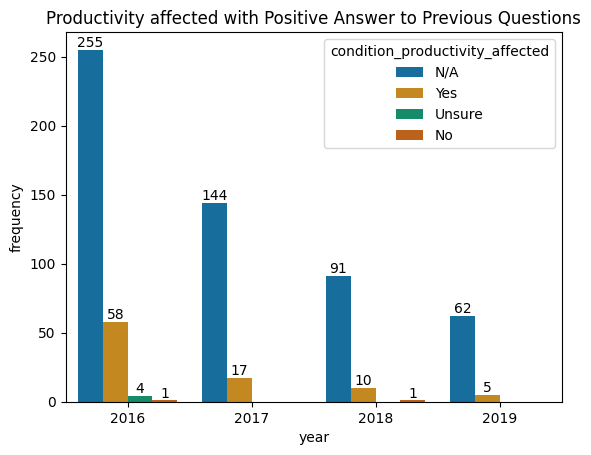

In [1106]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText family_hist
    FROM Answer
    WHERE QuestionID = 6), 

t4 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'Maybe'
    WHEN AnswerText = -1 THEN 'NA' 
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32), 

t5 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34),

t6 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33), 

t7 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' 
    ELSE AnswerText END AS condition_productivity_affected
    FROM Answer
    WHERE QuestionID = 54)


SELECT t1.SurveyID year, t7.condition_productivity_affected, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
JOIN t4
ON t3.UserID = t4.UserID
JOIN t5 
ON t4.UserID = t5.UserID
JOIN t6
ON t5.UserID = t6.UserID
JOIN t7
ON t6.UserID = t7.UserID
WHERE t6.current_mental_health_disorder LIKE 'yes' AND t4.past_mental_health_disorder LIKE 'yes' AND t3.family_hist LIKE 'yes' AND (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')
ax = sns.barplot(c, x="year", y="frequency", hue="condition_productivity_affected", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)


ax.set(title="Productivity affected with Positive Answer to Previous Questions")

As compared to the result from the previous question, with positive answers to mental health issues in the past, present, and family history, work productivity is more affected by mental health issues in the USA, UK, and Canada. 

Finally, looking at the percentage of work time affected: given a positive response to the previous questions: 
- 'Yes' to current mental health disorder, 
- 'Yes' to past mental health disorder
- 'Yes' to having a family history of mental health disorders, 
- 'Yes' to having their work productivity affected by a mental health disorder, 

do participants working in the USA, UK, or Canada find their work productivity affected from 2016-2019? 

[Text(0.5, 1.0, 'Percent Work Affected with Previous Positive Answers')]

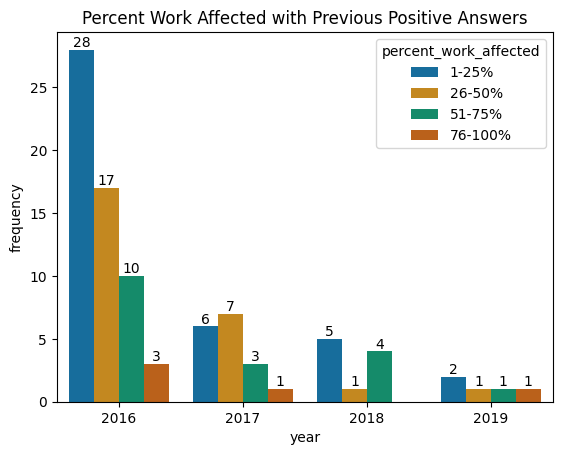

In [1107]:
q = """ 
WITH t1 AS (
    SELECT SurveyID, UserID, AnswerText,
    CASE WHEN AnswerText LIKE 'Female' THEN 'Female'
    WHEN AnswerText LIKE '%Female-identified%' THEN 'Female'
    WHEN AnswerText LIKE '%Woman-identified%' THEN 'Female'
    WHEN AnswerText LIKE 'female' THEN 'Female' 
    WHEN AnswerText LIKE 'MALE' THEN 'Male'
    WHEN AnswerText LIKE '%Male%' THEN 'Male' 
    WHEN AnswerText LIKE 'Masculine' THEN 'Male'  
    WHEN AnswerText LIKE 'Ostensibly Male' THEN 'Male' 
    WHEN AnswerText LIKE 'male' THEN 'Male'  
    Else 'Other' END AS gender
    FROM Answer
    WHERE QuestionID = 2), 

t2 AS (
    SELECT UserID, AnswerText work_country
    FROM Answer
    WHERE QuestionID = 50), 

t3 AS (
    SELECT UserID, AnswerText family_hist
    FROM Answer
    WHERE QuestionID = 6), 

t4 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Possibly' THEN 'Maybe'
    WHEN AnswerText = -1 THEN 'NA' 
    ELSE AnswerText END AS past_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 32), 

t5 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    ELSE AnswerText END AS diagnosis
    FROM Answer
    WHERE QuestionID = 34),

t6 AS (
    SELECT UserID, CASE WHEN AnswerText LIKE 'Yes' THEN 'Yes' 
    WHEN AnswerText LIKE 'No' THEN 'No' 
    ELSE 'Unknown' END AS current_mental_health_disorder
    FROM Answer
    WHERE QuestionID = 33), 

t7 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' 
    WHEN AnswerText LIKE 'Not applicable to me' THEN 'N/A' 
    ELSE AnswerText END AS condition_productivity_affected
    FROM Answer
    WHERE QuestionID = 54), 

t8 AS (
    SELECT UserID, CASE WHEN AnswerText = -1 THEN 'N/A' ELSE AnswerText END AS percent_work_affected
    FROM Answer
    WHERE QuestionID = 55)


SELECT t1.SurveyID year, t8.percent_work_affected, COUNT(t1.SurveyID) frequency
FROM t1
JOIN t2
ON t1.UserID = t2.UserID
JOIN t3
ON t2.UserID = t3.UserID
JOIN t4
ON t3.UserID = t4.UserID
JOIN t5 
ON t4.UserID = t5.UserID
JOIN t6
ON t5.UserID = t6.UserID
JOIN t7
ON t6.UserID = t7.UserID
JOIN t8 
ON t7.UserID = t8.UserID 
WHERE t7.condition_productivity_affected LIKE 'yes' AND t6.current_mental_health_disorder LIKE 'yes' AND t4.past_mental_health_disorder LIKE 'yes' AND t3.family_hist LIKE 'yes' AND (t2.work_country LIKE 'United States of America' OR t2.work_country LIKE 'United Kingdom' OR t2.work_country LIKE 'Canada')
GROUP BY 1, 2
ORDER BY frequency DESC
"""
c = pd.read_sql(q, connection)

sns.color_palette('colorblind')
ax = sns.barplot(c, x="year", y="frequency", hue="percent_work_affected", palette='colorblind')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.bar_label(ax.containers[2], fontsize=10)
ax.bar_label(ax.containers[3], fontsize=10)


ax.set(title="Percent Work Affected with Previous Positive Answers")

In the USA, UK, and Canada, when participants have answered 'yes' to previous questions examined as well as 'yes' to having their work affected by their mental health condition, the largest estimated work percentage affected is 1-25% in 2016. 

Conclusions: 
- Sample: men and women (mostly men) who work in the USA aged between 29-55. It is impossible to say that this data is a random selection of people or that survey entries have no influence on each other. From the examination of this data, most of it is taken from surveys during 2016-2019. 
- Of these people, most of them work in the tech industry in companies with varying sizes. 
- In general, employers provide mental health benefits, though about half of survey participants are not aware of these exact options. 
- In the USA, UK, and Canada: 
    - About half of survey participants have a family history of mental health issues.
    - Most of these people have sought help for mental health issues at some point (USA). This number changes to about half in the UK and in Canada. 
    - Most people have dealt with a past mental health disorder (females and other genders with higher proportions than males). 
    - A higher proportion of people in the United States say they have a current mental health disorder compared to the UK and to Canada. This proportion is also higher non-males. 
    - Throughout 2016-2019, about half of respondents of these nationalities have been diagnosed with a mental health disorder. 
    - The top three diagnosed mental health disorders are: 
        - Mood, anxiety, and attention deficit hyperactivity disorders. 

Conclusions: 
- With ineffective treatment, most people struggling with mental health issues find that it interferes with their work. 
- Doesn’t seem to be a big problem unless not treated effectively, but still seems to be an issue. Even with effective treatment, mental health issues most frequently are sometimes an issue in the workplace. 
- Most people in the USA, UK, and Canada have struggled or do struggle with mental health issues. 
- Having a family history and past mental health struggles seems to increase the chance of having a current mental health disorder. The contrary has been shown also. 

Improvements to be made: 
- Sampling bias and randomness 
- Examining more recent data
- Evaluating to what extent exactly that mental health issues affect workplace productivity. This has not been evaluated conclusively here. 